In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch 

device = torch.device('cuda')
print('Running on device: {}'.format(device))

mtcnn = MTCNN(
    image_size=256, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

Running on device: cuda


In [3]:
import clip.clip as clip 

CLIP_MODEL,  clip_img_processor =clip.load('ViT-B/32', jit=False)

In [4]:
from src.data_loader import read_data

train_data = read_data('train')
val_data = read_data('val')
test_data = read_data('test')

100%|██████████| 200/200 [00:00<00:00, 5846.37it/s]


In [7]:
from src.config import BATCH_SIZE
import random 
import numpy as np 
import torch 

from src.networks.face_model import face_model_dataset

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

def get_dataloader(data):
    dataset = face_model_dataset(data, clip_img_processor, mtcnn, resnet)
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,shuffle=True, worker_init_fn=seed_worker, generator=g)
    return data_loader
    
train_loader = get_dataloader(train_data)
val_loader = get_dataloader(val_data)
test_loader = get_dataloader(test_data)

CLIP preprocessing: 100%|██████████| 200/200 [00:41<00:00,  4.79it/s]


In [8]:
del resnet 
del mtcnn

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 2/2 [00:01<00:00,  1.12it/s]




For epoch = 0
Training Loss = 0.6178997091271661 | Training Accuracy = 0.01278409090909091
Validation Loss = 0.5268393456935883|Validation Accuracy = 0.03125




100%|██████████| 2/2 [00:01<00:00,  1.07it/s]




For epoch = 1
Training Loss = 0.36727660217068414 | Training Accuracy = 0.12575757575757576
Validation Loss = 0.3776344209909439|Validation Accuracy = 0.12651209677419356




100%|██████████| 2/2 [00:01<00:00,  1.08it/s]




For epoch = 2
Training Loss = 0.2741440148516135 | Training Accuracy = 0.1653409090909091
Validation Loss = 0.29994115233421326|Validation Accuracy = 0.14264112903225806




100%|██████████| 2/2 [00:01<00:00,  1.07it/s]




For epoch = 3
Training Loss = 0.26375994831323624 | Training Accuracy = 0.19535984848484847
Validation Loss = 0.27984078228473663|Validation Accuracy = 0.1123991935483871




100%|██████████| 2/2 [00:01<00:00,  1.06it/s]




For epoch = 4
Training Loss = 0.2798015319488265 | Training Accuracy = 0.18238636363636365
Validation Loss = 0.2844875156879425|Validation Accuracy = 0.11189516129032258




100%|██████████| 2/2 [00:01<00:00,  1.05it/s]




For epoch = 5
Training Loss = 0.3017506274310025 | Training Accuracy = 0.18219696969696972
Validation Loss = 0.2825496345758438|Validation Accuracy = 0.14163306451612903




100%|██████████| 2/2 [00:01<00:00,  1.03it/s]




For epoch = 6
Training Loss = 0.3081886504184116 | Training Accuracy = 0.22481060606060607
Validation Loss = 0.289132684469223|Validation Accuracy = 0.14415322580645162




100%|██████████| 2/2 [00:01<00:00,  1.04it/s]




For epoch = 7
Training Loss = 0.3178720304911787 | Training Accuracy = 0.18200757575757576
Validation Loss = 0.3060014992952347|Validation Accuracy = 0.14264112903225806




100%|██████████| 2/2 [00:01<00:00,  1.04it/s]




For epoch = 8
Training Loss = 0.3095282065597447 | Training Accuracy = 0.2122159090909091
Validation Loss = 0.31430064141750336|Validation Accuracy = 0.15776209677419356




100%|██████████| 2/2 [00:01<00:00,  1.03it/s]




For epoch = 9
Training Loss = 0.29401329227469186 | Training Accuracy = 0.21931818181818183
Validation Loss = 0.31545449793338776|Validation Accuracy = 0.04788306451612903




100%|██████████| 2/2 [00:01<00:00,  1.01it/s]




For epoch = 10
Training Loss = 0.2996835647658868 | Training Accuracy = 0.2035037878787879
Validation Loss = 0.316201388835907|Validation Accuracy = 0.07963709677419355




100%|██████████| 2/2 [00:01<00:00,  1.03it/s]




For epoch = 11
Training Loss = 0.29741751809011807 | Training Accuracy = 0.16070075757575758
Validation Loss = 0.30983875691890717|Validation Accuracy = 0.07913306451612903




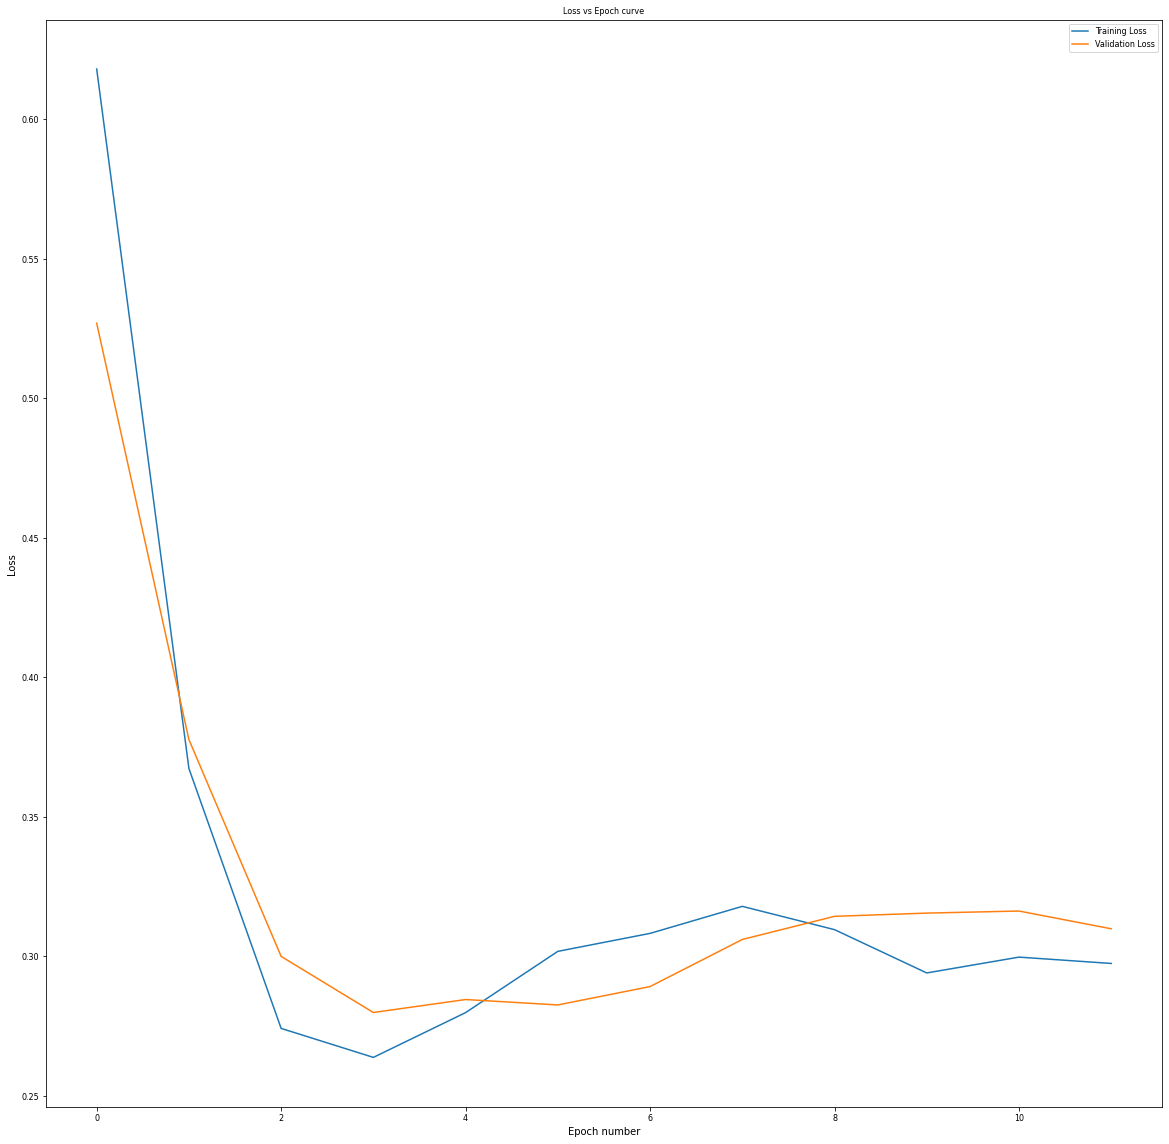

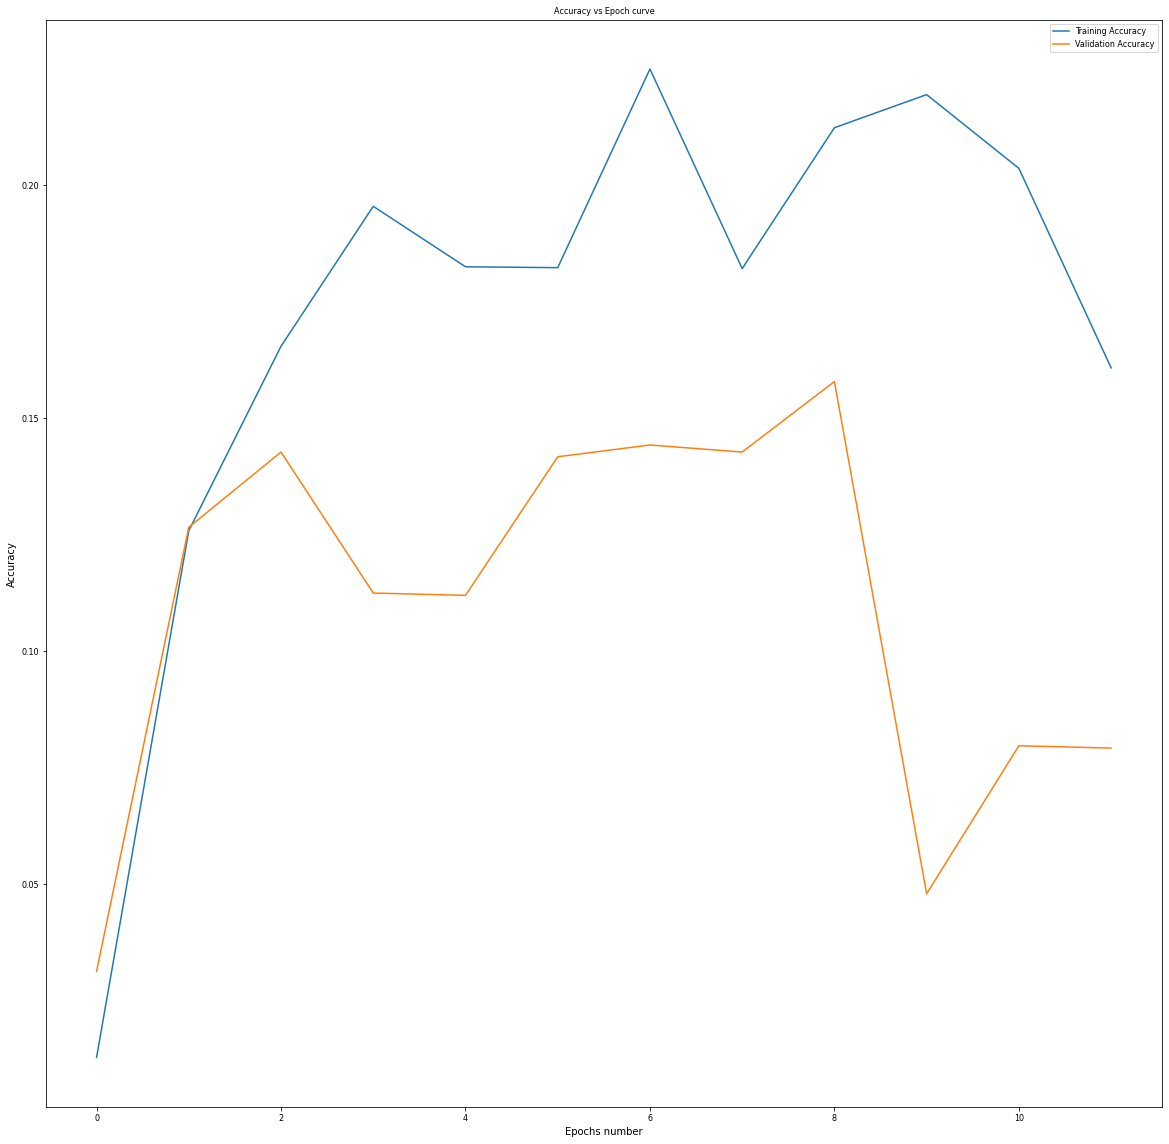

In [21]:
from src.trainer import Trainer
from src.networks.face_model import face_model_input_transformer, face_model
import torch.nn as nn
import torch 

trainer = Trainer(12)

#Set data
trainer.set_data(train_loader, val_loader)

#set model 
model = face_model(CLIP_MODEL).cuda()
input_transformer = face_model_input_transformer()
trainer.set_model(model, input_transformer)

#Backpropagation
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
trainer.set_optimizer(optimizer, loss_fn)
trainer.train(l2_r=1e-3)
trainer.plot()

In [22]:
trainer.test(test_loader)

100%|██████████| 22/22 [00:18<00:00,  1.22it/s]

Accuracy Score = 26.055312954876275
Macro F1 score Score = 16.388308661424738
Micro F1 score Score = 65.34186594813069


In [23]:
torch.save(model.state_dict(), f"Models/clip_bert_face.model")
